In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms 
import tqdm
import numpy as np
from torch.nn import ModuleList

In [2]:
import cv2

In [3]:
Iearning_rate = 1e-3 #lr 1e-1 일때 0.19정도이고, 1e-2 일때 0.83 정도이고, 1e-3 일때 0.87 정도이고, 1e-4일때 0.81 정도이고, 5e-5일때 0.75정도로 나옴
batch_size = 64

In [4]:
train_data_svhn = datasets.SVHN('D:SVHN', split='train', download=True, transform=transforms.Compose([transforms.Resize(28),transforms.ToTensor()]))
test_data_svhn = datasets.SVHN('D:SVHN', split='test', download=True, transform=transforms.Compose([transforms.Resize(28),transforms.ToTensor()]))

Using downloaded and verified file: D:SVHN\train_32x32.mat
Using downloaded and verified file: D:SVHN\test_32x32.mat


In [5]:
train_data_mnist = datasets.MNIST('D:datasets', train=True, download=True, transform=transforms.ToTensor())
test_data_mnist = datasets.MNIST('D:datasets', train=False, download=True, transform=transforms.ToTensor())

In [6]:
print(len(train_data_mnist))
print(len(test_data_mnist))
print(train_data_mnist[0][0].shape)


60000
10000
torch.Size([1, 28, 28])


In [7]:
#cv2로 mnist 이미지 만들기
def mnist_image_augment(mnist, scale=True, rotate=True, shear=True, colour=True, gaussian=False, invert=True):
    l = len(mnist)

    SC = np.random.normal(1, 0.3, size=l) # scale
    SH = np.random.normal(0, 1, size=(l, 3, 2)) # shear
    R = np.random.normal(0, 20, size=l) # rotate
    C = np.random.randint(21, size=l) # colour
    G = np.random.randint(30, size=l) # noise
    I = np.random.randint(2, size=l) # invert

    augmented = []

    for i, t in enumerate(mnist):
        X, y = t[0], t[1]
        X = X.numpy()
        X = (np.reshape(X, (28, 28, 1)) * 255).astype(np.uint8)
        
        if scale or rotate:
            if scale:
                sc = SC[i] if SC[i] >= 0 else -SC[i]
            else:
                sc = 1
            r = R[i] if rotate else 0

            M = cv2.getRotationMatrix2D((14, 14), r, sc)
            X = cv2.warpAffine(X, M, (28, 28))
        
        if shear:
            pts1 = np.float32([[4, 4], [4, 24], [24, 4]])
            pts2 = np.float32([[4+SH[i][0][0], 4+SH[i][0][1]], [4+SH[i][1][0], 24+SH[i][1][1]], [24+SH[i][2][0], 4+SH[i][2][1]]])
            
            M = cv2.getAffineTransform(pts1, pts2)
            X = cv2.warpAffine(X, M, (28, 28))
        
        if colour:
            X = cv2.applyColorMap(X, C[i])
        
        if gaussian:
            g = G[i]/100 if G[i] > 0 else - G[i]/100
            gauss = np.random.normal(0, g**0.5, X.shape)
            X = (X + gauss).astype(np.uint8)

        if invert:
            X = cv2.bitwise_not(X)
        
        recover = (np.reshape(X, (28, 28, 3)) / 255).astype(np.float32)   
        X = torch.from_numpy(recover)
        augmented.append([X, y])
    
    return augmented

In [8]:
augmented_train = mnist_image_augment(train_data_mnist)
augmented_test = mnist_image_augment(test_data_mnist)

In [9]:
def augment_reshape(augmented):
    newaug = []
    for i in range(len(augmented)):
        augment = torch.Tensor(augmented[i][0])
        #augment = augmented[i][0].numpy()
        augment = (np.reshape(augment, (28, 28, 3)))
        augment = np.transpose(augment, (2,0,1))
        newaug.append([augment, augmented[i][1]])
    return newaug

In [10]:
train_data_trans_mnist = augment_reshape(augmented_train)
test_data_trans_mnist = augment_reshape(augmented_test)

In [11]:
train_datas = torch.utils.data.ConcatDataset([train_data_trans_mnist, train_data_svhn])
test_datas = torch.utils.data.ConcatDataset([test_data_trans_mnist, test_data_svhn])

In [12]:
train_set, val_set = torch.utils.data.random_split(train_datas, [123257,10000])

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_datas, batch_size = batch_size, shuffle=True)

In [15]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.8
        
        n_channels_1 = 6
        n_channels_2 = 16
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, n_channels_1, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(n_channels_1),
            #사이에 batch_normalization을 해야함
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_channels_1, n_channels_2, kernel_size=5, stride=1),
            torch.nn.BatchNorm2d(n_channels_2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc3 = torch.nn.Linear(4 * 4 * n_channels_2, 120, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc3,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        self.fc4 = torch.nn.Linear(120, 80, bias=True)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc4,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        self.fc5 = torch.nn.Linear(80, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.fc5(out)
        return out

In [16]:
def test(data_loader, model):
    model.eval()
    n_predict = 0
    n_correct = 0
    with torch.no_grad():
        for X, Y in tqdm.tqdm(data_loader):
            y_hat = model(X)
            y_hat.argmax()
            
            _, predicted = torch.max(y_hat, 1)
             
            n_predict += len(predicted)
            n_correct += (Y == predicted).sum()
            
    accuracy = n_correct/n_predict
    print(f"Accuracy: {accuracy} ()")

In [17]:
model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Iearning_rate)

In [18]:
#training
training_epochs = 5

for epoch in range(training_epochs):
    model.train()
    cost = 0
    n_batches = 0
    for X, Y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, Y)
        loss.backward()
        optimizer.step()
        
        cost += loss.item()
        n_batches += 1
        
    cost /= n_batches
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, cost))
    print("Dev")
    test(dev_loader, model)

  9%|███████▏                                                                        | 14/157 [00:00<00:01, 132.43it/s]

[Epoch:    1] cost = 1.10919599
Dev


  0%|▎                                                                                | 7/1926 [00:00<00:28, 67.49it/s]

Accuracy: 0.7878000140190125 ()


  9%|███████▏                                                                        | 14/157 [00:00<00:01, 134.98it/s]

[Epoch:    2] cost = 0.652603521
Dev


  0%|▎                                                                                | 8/1926 [00:00<00:25, 74.27it/s]

Accuracy: 0.8417999744415283 ()


 17%|█████████████▊                                                                  | 27/157 [00:00<00:00, 133.62it/s]

[Epoch:    3] cost = 0.559351345
Dev


  0%|▍                                                                                | 9/1926 [00:00<00:23, 82.79it/s]

Accuracy: 0.861299991607666 ()


  8%|██████▌                                                                         | 13/157 [00:00<00:01, 129.06it/s]

[Epoch:    4] cost = 0.511287958
Dev


  0%|▎                                                                                | 8/1926 [00:00<00:24, 77.88it/s]

Accuracy: 0.8661999702453613 ()


  8%|██████▌                                                                         | 13/157 [00:00<00:01, 125.33it/s]

[Epoch:    5] cost = 0.477124299
Dev


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 141.44it/s]

Accuracy: 0.8780999779701233 ()


In [19]:
test(test_loader, model)

100%|███████████████████████████████████████████████████████████████████████████████| 563/563 [00:04<00:00, 115.92it/s]

Accuracy: 0.8692551255226135 ()


In [20]:
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize = (20,2))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

torch.Size([64, 3, 28, 28])
(3, 32, 1922)


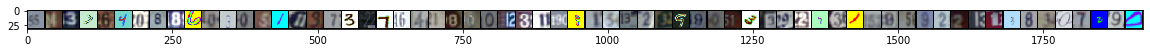

GroundTruth
   5   4   3   7   6   4   0   8   8   6   0   3   0   5   1   1   3   7   3   2   7   6   4   1   8   0   0   1   3   1   9   9   1   5   1   2   3   9   9   0   1   3   3   9   2   7   3   1   5   9   5   9   2   2   1   1   3   8   3   0   7   2   9   0
Prediction
   5   4   3   7   6   4   0   8   8   6   0   3   0   5   1   1   3   7   3   2   7   6   4   1   3   8   0   1   3   1   9   9   1   5   3   2   3   5   9   0   1   3   6   9   2   7   3   1   5   9   5   9   2   2   1   2   2   8   3   0   7   2   9   0


In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow = batch_size))
print('GroundTruth')
print(" "+' '.join('%3s' % label.item() for label in labels))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Prediction')
print(" "+' '.join('%3s' % label.item() for label in predicted))